In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

**Mount the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports and Configs

In [ ]:
!pip install --upgrade tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.3 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade keras-cv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 44.5 MB/s eta 0:00:00


**Imports**

In [ ]:
# Default Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv as kcv
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

!wget -q https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz

Using TensorFlow backend


**Randomnes and Configurations**

In [ ]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
use_tpu = True#@param {type:"boolean"}

if 'COLAB_TPU_ADDR' in os.environ and use_tpu:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  use_tpu = False


if use_tpu:
  tpu_address = TF_MASTER
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

**Defining Functions**

In [ ]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()
def plot_confusion_matrix(model, test, steps, figsize, name_jpg):
  # Compute the confusion matrix
  y_pred = model.predict(test, verbose=0, steps=steps)
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  cm = confusion_matrix(true_categories, y_pred)

  # Compute classification metrics
  accuracy = accuracy_score(true_categories, y_pred)
  precision = precision_score(true_categories, y_pred, average='macro')
  recall = recall_score(true_categories, y_pred, average='macro')
  f1 = f1_score(true_categories, y_pred, average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(name_jpg)
  plt.show()
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

#plot_images(IMGS[:25], LBLS[:25], 0, 5, 5)

# Test
def test_prediction(model, test, steps):
  y_pred = model.predict(test, verbose=0, steps=steps)
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  test_accuracy = accuracy_score(true_categories, y_pred)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

def random_90_rotation_flip(images, labels, num_gen):
    gen_images_shape = (num_gen, images.shape[1], images.shape[2], images.shape[3])
    gen_images = np.zeros(gen_images_shape)
    # array of labels (strings) for generated images
    gen_labels = np.empty(num_gen, dtype=object)
    ops = []
    for j in range(1, 4):
        ops.append(lambda x: np.rot90(x, j + 1))
    ops.append(lambda x: np.flipud(x))
    for j in range(1, 4):
        ops.append(lambda x: np.rot90(np.flipud(x), j + 1))
    # random choice of num_gen operations from len(images)*len(ops) operations
    idxs = range(len(images) * len(ops))
    idxs = np.random.choice(idxs, num_gen, replace=False)
    i = 0
    for idx in idxs:
        gen_images[i] = ops[idx % len(ops)](images[idx // len(ops)])
        gen_labels[i] = labels[idx // len(ops)]
        i += 1
    return gen_images, gen_labels

### Data Initizialization

In [ ]:
# Initializate
images, labels = np.load('public_data_clean.npz', allow_pickle=True).values()

print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])

Images shape:  (4850, 96, 96, 3)
Labels shape:  (4850,)


In [ ]:
healthy_idxs = np.argwhere(labels == 0).flatten()
unhealthy_idxs = np.argwhere(labels == 1).flatten()
delta = len(healthy_idxs) - len(unhealthy_idxs)
# remove temporarlly some healthy images so that the classes are balanced
idxs = np.random.choice(healthy_idxs, delta, replace=False)

partial_images = np.delete(images, idxs, axis=0)
partial_labels = np.delete(labels, idxs, axis=0)

In [ ]:
# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    partial_images,
    partial_labels,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = partial_labels
)

In [ ]:
# add back the temporarily removed healthy images to the training set
X_train = np.concatenate((X_train, images[idxs]))
y_train = np.concatenate((y_train, labels[idxs]))

# augment all unhealthy images in the training set
unhealthy_images = X_train[y_train == 1]
unhealthy_labels = y_train[y_train == 1]
# make sure that the number of images is a multiple of 128
num_gen = 128 * (len(unhealthy_images) * 6 // 128) - len(unhealthy_images)
gen_images, gen_labels = random_90_rotation_flip(unhealthy_images, unhealthy_labels, num_gen)
X_train = np.concatenate((X_train, gen_images))
y_train = np.concatenate((y_train, gen_labels))
print("Number of unhealthy images in the training set: ", len(X_train[y_train == 1]))

# augment all healthy images in the training set so that the number of healthy and unhealthy images is the same
healthy_images = X_train[y_train == 0]
healthy_labels = y_train[y_train == 0]
num_gen = len(unhealthy_images) + num_gen - len(healthy_images)
gen_images, gen_labels = random_90_rotation_flip(healthy_images, healthy_labels, num_gen)
X_train = np.concatenate((X_train, gen_images))
y_train = np.concatenate((y_train, gen_labels))
print("Number of healthy images in the training set: ", len(X_train[y_train == 0]))

# clear memory from unused variables
del images, labels, partial_images, partial_labels, unhealthy_images, unhealthy_labels, healthy_images, healthy_labels, gen_images, gen_labels

Number of unhealthy images in the training set:  9088
Number of healthy images in the training set:  9088


In [ ]:
y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)

# Get the Shape of input and output layers
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



In [ ]:
half_len = len(X_train)//2
train_dataset = tf.data.Dataset.from_tensor_slices((X_train[:half_len], y_train[:half_len])).concatenate(tf.data.Dataset.from_tensor_slices((X_train[half_len:], y_train[half_len:])))
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
if use_tpu:
  BATCH_SIZE = 128
else:
  BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (96, 96)

def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}


def prepare_trainset(dataset):
    return (
            dataset
            .cache()
            .shuffle(1000, reshuffle_each_iteration=True)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

def prepare_valset(dataset):
    return (
            dataset
            .cache()
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

def prepare_testset(dataset):
    return (
            dataset
            .cache()
            .batch(BATCH_SIZE, drop_remainder=True)
        )


train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

Exception ignored in: <function Executor.__del__ at 0x787b8c32aa70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


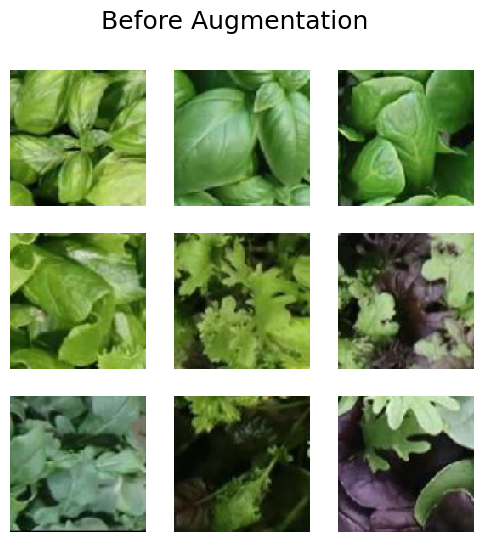

In [ ]:
visualize_dataset(train_dataset, title="Before Augmentation")

**Augmentation Layers**

In [ ]:
class NothingUp(kcv.layers.BaseImageAugmentationLayer):
    def __init__(self, seed=None, **kwargs):
        super().__init__(seed=seed, **kwargs)
        self.seed = seed

    def _batch_augment(self, inputs):
        self._validate_inputs(inputs)
        return inputs

    def _augment(self, inputs):
        raise ValueError(
            "NothingUp received a single image to `call`. The layer relies on "
            "combining multiple examples, and as such will not behave as "
            "expected. Please call the layer with 2 or more samples."
        )

    def _validate_inputs(self, inputs):
        images = inputs.get("images", None)
        labels = inputs.get("labels", None)

        if images is None or (
            labels is None
        ):
            raise ValueError(
                "NothingUp expects inputs in a dictionary with format "
                '{"images": images, "labels": labels}. '
                f"Got: inputs = {inputs}."
            )

        if labels is not None and not labels.dtype.is_floating:
            raise ValueError(
                f"NothingUp received labels with type {labels.dtype}. "
                "Labels must be of type float."
            )

    def get_config(self):
        config = {
            "seed": self.seed,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

Exception ignored in: <function Executor.__del__ at 0x787b8c32aa70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


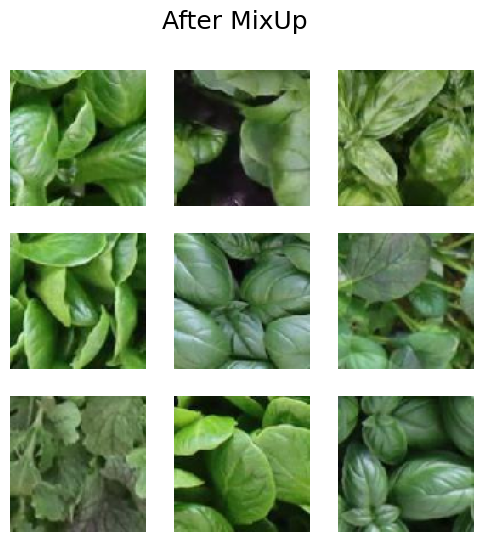

In [ ]:
rand_mixup = kcv.layers.RandomChoice([NothingUp(), kcv.layers.MixUp()], batchwise=True)


def apply_rand_mixup(inputs):
    inputs = rand_mixup(inputs)
    return inputs

res = train_dataset.map(apply_rand_mixup, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After RandMixUp")

Exception ignored in: <function Executor.__del__ at 0x787b8c32aa70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


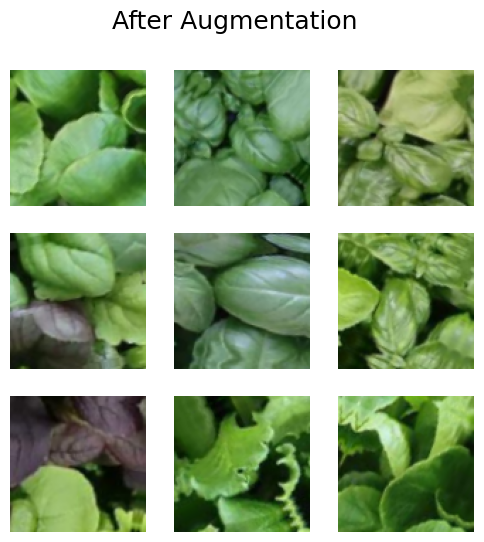

In [ ]:
aug = tfk.Sequential([
    tkl.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
    tkl.RandomFlip(),
    tkl.RandomRotation(factor=0.5)
])

def apply_aug(inputs):
    inputs["images"] = aug(inputs["images"])
    return inputs

res = train_dataset.map(apply_aug, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After Augmentation")

### Training

In [ ]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

train_dataset = (
    train_dataset
    .map(apply_aug, num_parallel_calls=AUTOTUNE)
    .map(apply_rand_mixup, num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

**Define the Model**

In [ ]:
from keras.applications.convnext import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  res = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
  )

  res.trainable = False
  input_layer = tkl.Input(input_shape)

  x = preprocess_input(input_layer)
  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x)
  x = tkl.Dense(units=128,activation=tkl.LeakyReLU(alpha=0.3))(x)
  x = tkl.Dropout(0.7)(x)

  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)
  model = tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
      metrics=['accuracy', 'auc']
  )

  return model

if use_tpu:
  with strategy.scope():
    model = apple_elixir_model(input_shape, output_shape)
else:
  model = apple_elixir_model(input_shape, output_shape)

350926856/350926856 [==============================] - 2s 0us/step


**Train the Model**

In [ ]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

callbacks = [early_stopping, lr_scheduler]

history = model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
142/142 [==============================] - 46s 137ms/step - loss: 0.3338 - accuracy: 0.8672 - auc: 0.9386 - val_loss: 3.2908 - val_accuracy: 0.4980 - val_auc: 0.5550 - lr: 0.0010
Epoch 2/300
142/142 [==============================] - 5s 36ms/step - loss: 0.3043 - accuracy: 0.8888 - auc: 0.9451 - val_loss: 2.8801 - val_accuracy: 0.4980 - val_auc: 0.5902 - lr: 0.0010
Epoch 3/300
142/142 [==============================] - 6s 44ms/step - loss: 0.3050 - accuracy: 0.8808 - auc: 0.9429 - val_loss: 2.6989 - val_accuracy: 0.5000 - val_auc: 0.6040 - lr: 0.0010
Epoch 4/300
142/142 [==============================] - 5s 35ms/step - loss: 0.3059 - accuracy: 0.8807 - auc: 0.9442 - val_loss: 2.6762 - val_accuracy: 0.5000 - val_auc: 0.5927 - lr: 0.0010
Epoch 5/300
142/142 [==============================] - 5s 35ms/step - loss: 0.3052 - accuracy: 0.8823 - auc: 0.9420 - val_loss: 2.7154 - val_accuracy: 0.5000 - val_auc: 0.5877 - lr: 0.0010
Epoch 6/300
142/142 [==============================] 

### Saving and Plotting

In [ ]:
NAME_MODEL = "ConvNeXtCV_Aug_MixUp_001"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Plots Loss**

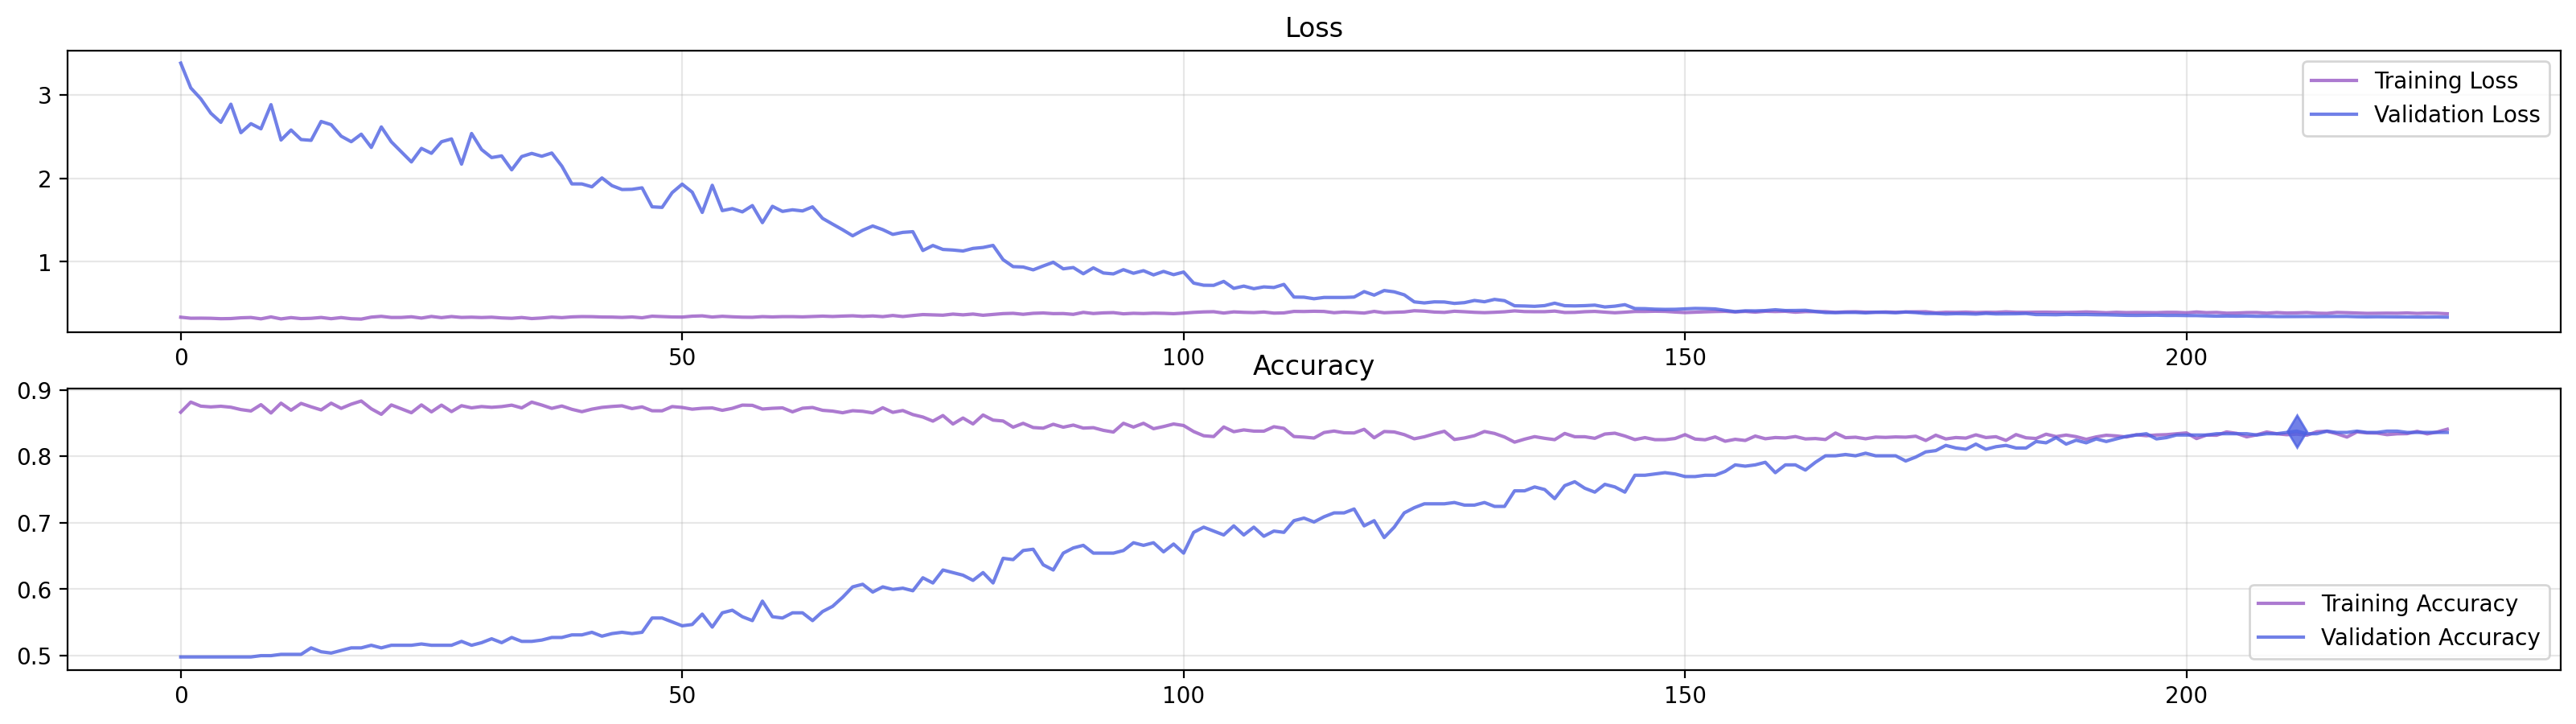

In [ ]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

In [ ]:
plot_confusion_matrix(model, val_dataset, len(X_val) // BATCH_SIZE, (5,4), NAME_CMATRIX)

**Save the Model**

In [ ]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  model.save(NAME_MODEL, options=save_locally)
else:
  model.save(NAME_MODEL)

**Zip Model and Plots**

In [ ]:
!zip -q -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

In [ ]:
!cp {NAME_MODEL}.zip drive/MyDrive/

**Delete the Model**

In [ ]:
del model, history

## Tuning

**Load the Model**

In [ ]:
if use_tpu:
  with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    ft_model = tf.keras.models.load_model(NAME_MODEL, options=load_locally)
else:
  ft_model = tfk.models.load_model(NAME_MODEL)

**Count the Layers**

In [ ]:
ft_model.get_layer('convnext_base').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   c += 1

print("Layers: ",c)
print()

Layers:  295



**Train only the Last Layers**

In [ ]:
# Change the number of fixed layers gradually ex: 200 -> 100 -> 0
N_LAYER = 100
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:N_LAYER]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

**Train the Tuning Model**

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',         # Metric to monitor (validation mean squared error in this case)
    patience=5,                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                     # Minimum learning rate
)

callbacks = [early_stopping, lr_scheduler]

history = ft_model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
142/142 [==============================] - 14s 96ms/step - loss: 0.0497 - accuracy: 0.9938 - val_loss: 0.3987 - val_accuracy: 0.9199 - lr: 6.8719e-05
Epoch 2/300
142/142 [==============================] - 11s 75ms/step - loss: 0.0470 - accuracy: 0.9947 - val_loss: 0.3831 - val_accuracy: 0.9160 - lr: 6.8719e-05
Epoch 3/300
142/142 [==============================] - 12s 84ms/step - loss: 0.0457 - accuracy: 0.9942 - val_loss: 0.3566 - val_accuracy: 0.9219 - lr: 6.8719e-05
Epoch 4/300
142/142 [==============================] - 11s 75ms/step - loss: 0.0520 - accuracy: 0.9927 - val_loss: 0.3873 - val_accuracy: 0.9141 - lr: 6.8719e-05
Epoch 5/300
142/142 [==============================] - 11s 75ms/step - loss: 0.0488 - accuracy: 0.9941 - val_loss: 0.3782 - val_accuracy: 0.9160 - lr: 6.8719e-05
Epoch 6/300
142/142 [==============================] - 12s 84ms/step - loss: 0.0502 - accuracy: 0.9933 - val_loss: 0.3547 - val_accuracy: 0.9238 - lr: 6.8719e-05
Epoch 7/300
142/142 [=======

### Saving and Plotting

In [ ]:
FT_NAME = NAME_MODEL+"_Tuning_2"
FT_PLOT = NAME_PLOT+"_Tuning_2"
FT_CMATRIX = NAME_CMATRIX+"_Tuning_2"

**Plot Loss**

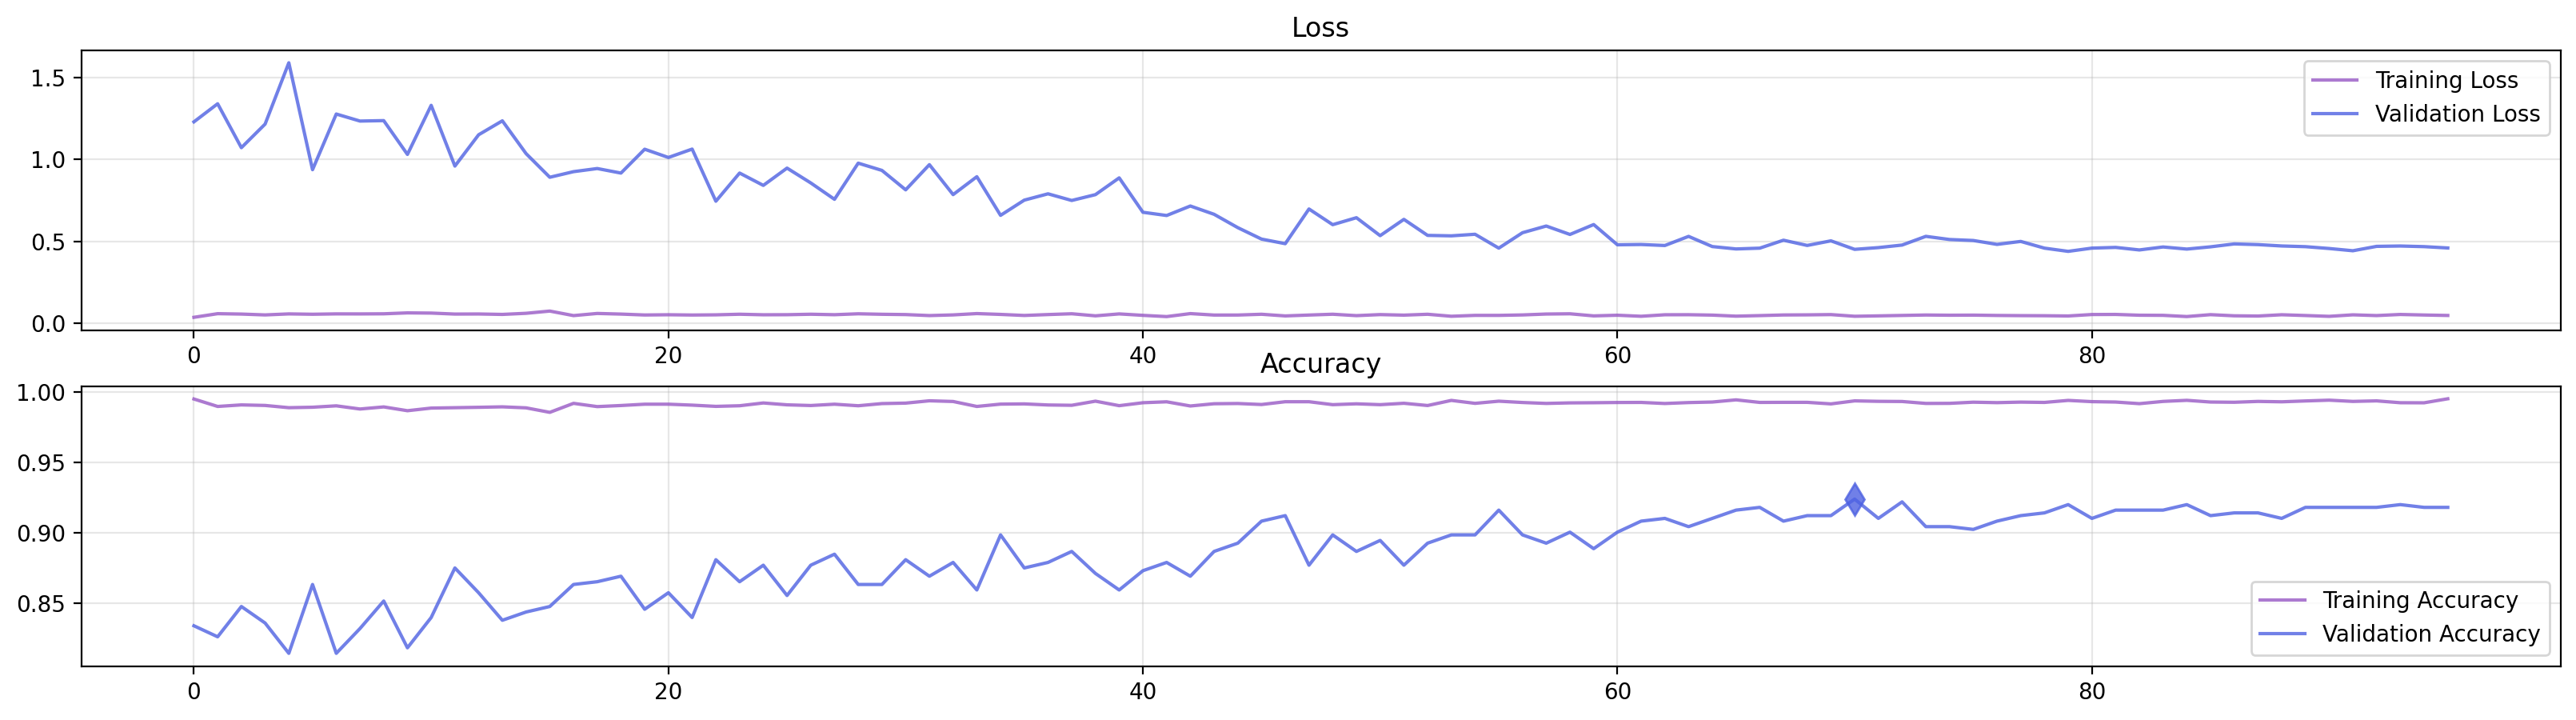

In [ ]:
plot_losses(history, (20,5), FT_PLOT)

**Plot Confusion Matrix**

In [ ]:
plot_confusion_matrix(ft_model, val_dataset, len(X_val) // BATCH_SIZE, (5,4), FT_CMATRIX)

KeyboardInterrupt: ignored

**Save the Model**

In [ ]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  ft_model.save(FT_NAME, options=save_locally)
else:
  ft_model.save(FT_NAME)

**Zip the Model and the Plots**

In [ ]:
!zip -q -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png

In [ ]:
!cp {FT_NAME}.zip drive/MyDrive/